In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
from aesim.simba import ProjectRepository

# Open and Run SIMBA Project

In [7]:
file_path = os.path.join(os.getcwd(), "pfc_totem_pole.jsimba")
project = ProjectRepository(file_path)
design = project.GetDesignByName('3. PFC totem pole closed loop')
job = design.TransientAnalysis.NewJob()
status = job.Run()
print (job.Summary())

========== 0 Error(s), 0 Warning(s) ==========
Job duration: 7,2090652 seconds.



# Power Factor Calculation

Power Factor 99.9993 %


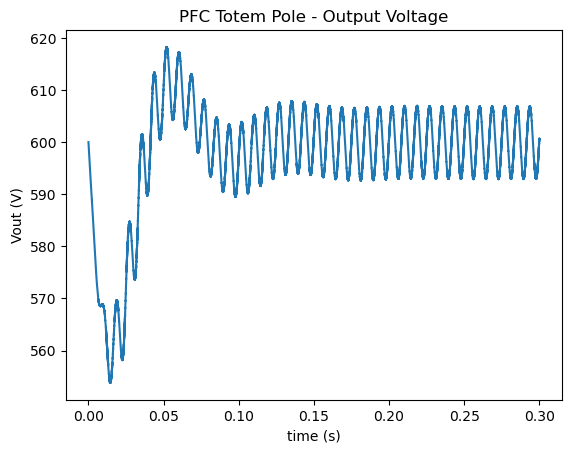

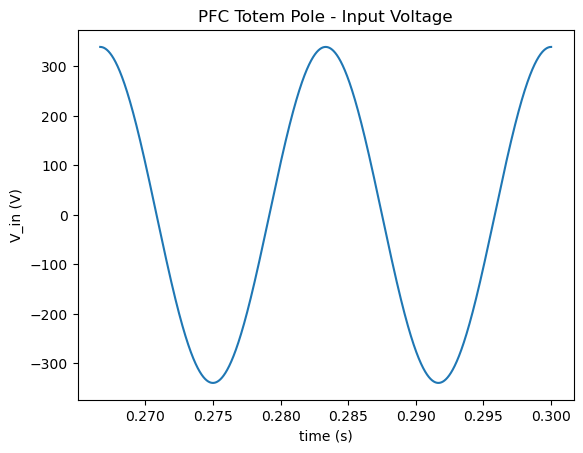

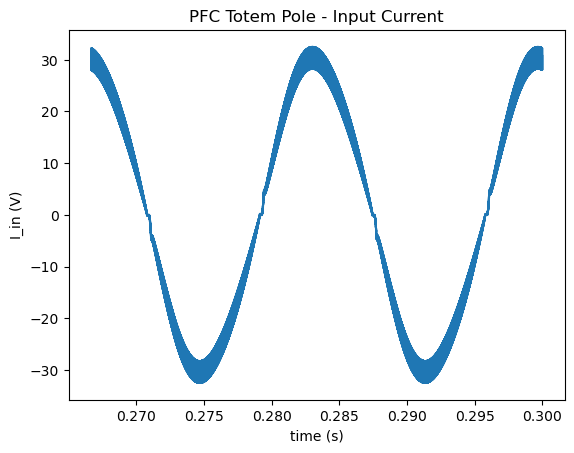

In [8]:
time= job.TimePoints
V_out= np.array(job.GetSignalByName('R3 - Voltage').DataPoints)

V_in= np.array(job.GetSignalByName('AC1 - Voltage').DataPoints)
I_in= np.array(job.GetSignalByName('AC1 - Current').DataPoints)

#%% Plot Output voltage
fig, ax = plt.subplots()
ax.set_title("PFC Totem Pole - Output Voltage")
ax.set_ylabel('Vout (V)')
ax.set_xlabel('time (s)')
ax.plot(time,V_out)

# Get the two last periods of the input signals
time_end = time[-1]
time_start = time_end - 2*1/60 ; # two periods at 60 Hz
index_time_start = next((i for i, t in enumerate(time) if t >= time_start), -1)
time_2T = time[index_time_start:]
V_in = V_in[index_time_start:]
I_in1 = I_in[index_time_start:]

fig, ax = plt.subplots()
ax.set_title("PFC Totem Pole - Input Voltage")
ax.set_ylabel('V_in (V)')
ax.set_xlabel('time (s)')
ax.plot(time_2T,V_in)

fig, ax = plt.subplots()
ax.set_title("PFC Totem Pole - Input Current")
ax.set_ylabel('I_in (V)')
ax.set_xlabel('time (s)')
ax.plot(time_2T,I_in1)

def power_factor(voltage, current, time):
    apparent_power = np.trapz(voltage * current, time)
    reactive_power = np.trapz(voltage * np.sin(np.arctan2(current, voltage)), time)
    true_power = np.sqrt(apparent_power**2 - reactive_power**2)
    return true_power / apparent_power

print("Power Factor: {0:.4f} %".format(100*power_factor(V_in, I_in1, time_2T)))

# THD Calculation

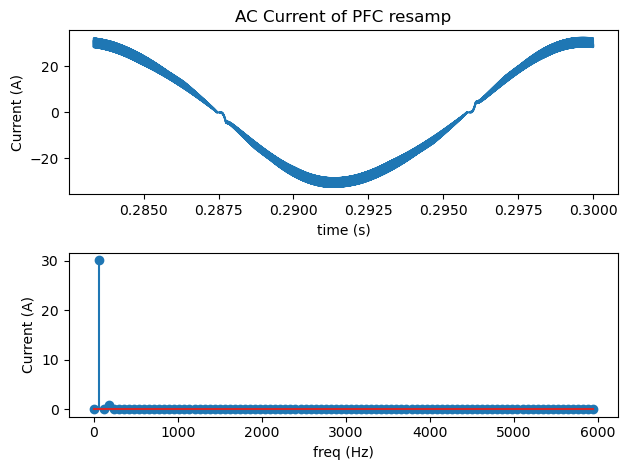

Fundamental THD is 3.137 %



In [9]:
fo = 60
N = 10000
end_time = np.round(time[-1], decimals=1)
time_resamp = np.linspace(end_time - 1 / fo, end_time, N, endpoint=False)
ac_current_resamp = np.interp(time_resamp, time, I_in)
fstep = fo
freq = np.fft.rfftfreq(N) * fstep * N
freqval = np.abs(np.fft.rfft(ac_current_resamp)) / N
freqval[1:] = freqval[1:] * 2

# Get only 'max_index' harmonics
max_index = 100
freq = freq[:max_index]
freqval = freqval[:max_index]

# Plot
fig, axes = plt.subplots(2)
axes[0].set_title("AC Current of PFC resamp")
axes[0].set_ylabel('Current (A)')
axes[0].set_xlabel('time (s)')
axes[0].plot(time_resamp, ac_current_resamp)

axes[1].set_ylabel('Current (A)')
axes[1].set_xlabel('freq (Hz)')
axes[1].stem(freq, freqval)
fig.tight_layout()
plt.show()

# %%
# Compute THD
thd_f = np.sqrt(sum(freqval[2:]**2)) / freqval[1]
print('Fundamental THD is {0:.3f} %'.format(thd_f * 100) + "\n")